In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np 
from scipy.integrate import quad
from math import *
import pylab 
from numpy.linalg import inv
import pandas as pd
from iminuit import Minuit, describe

In [2]:
# Physical constants
clight = 299792.458
H0 = 0.00007304 # Riess et al., 2022: H0 = 73.04 ± 1.04 km s−1 Mpc−1; Riess et al. 2016: H0 = 73.24 ± 1.74 km s−1 Mpc−1

m_step = 10.13
tau = 0.001

# Baseline parameters from JLA
omgM0 = 0.295   # = 0.295 +- 0.034
M_b0 = -19.05   # = −19.05 +- 0.02 
alpha0 = 0.141  #  alpha0         =    0.141 +- 0.006 
beta0 = 3.101   #  beta0          =    3.101 +- 0.075  
gamma0 = 0.     #  gamma0         =    0
morph0 = 0.     #  morph0         =    0


# # Baseline parameters from Ancillary_G10.FITRES
# omgM0 = 0.298     # = 0.298 +- 0.022
# M_b0 = -19.3
# alpha0 = 0.15424  #  alpha0         =    0.15424 +-  0.00553   
# beta0 = 3.02371   #  beta0          =    3.02371 +-  0.06431   
# gamma0 = 0.05271  #  gamma0         =    0.05271 +-  0.00917 

# # Baseline parameters from Ancillary_С11.FITRES
# omgM0 = 0.298     # = 0.298 +- 0.022
# M_b0 = -19.3
# alpha0 = 0.15648  #  alpha0         =    0.15648 +-  0.00539  
# beta0 = 3.68895   #  beta0          =    3.68895 +-  0.08882    
# gamma0 = 0.05391  #  gamma0         =    0.05391 +-  0.00912

In [3]:
# Comoving radial coordinate (c not included) corresponding to redshift z = c int_0^z dz/H(z)
# in LambdaCDM flat model
def intfun(z, omgM):
    return 1/sqrt(omgM*(1 + z)**3 + (1 - omgM))

In [4]:
# Luminosity Distance function
def fitfundL(zcmb, omgM):
    mu = []
    for i in range (len(zcmb)): 
        zz = zcmb[i]
        mu.append(dL_z(zz, zz, omgM)) 
    return mu 

In [5]:
# Luminosity Distance corresponding to a redshift z
def dL_z(zcmb, zhel, omgM):
    mu_zz = 5*log10((1 + zhel)*clight*(quad(intfun, 0, zcmb, args=(omgM))[0] / (10*H0)))
    return mu_zz

In [6]:
# Distance modulus for the observational data, delta_b calculated from delta_{mb,x1,c}
def muexp(SNdata, M_b, alpha, beta, gamma, morph):
    mu=[]
    list_ET, list_LT = get_morphology_lists()
    
    for i in range(len(SNdata['mB'])):
        exponent_input = np.clip(-(SNdata['HOST_LOGMASS'].iloc[i]-m_step)/tau, -np.inf, 700)
        delta_M = gamma / (1 + np.exp(exponent_input))
        delta_b = SNdata['biasCor_mB'].iloc[i] - beta*SNdata['biasCor_c'].iloc[i] + alpha*SNdata['biasCor_x1'].iloc[i]
        if SNdata['total_type'].iloc[i] in list_ET:
            mu.append(SNdata['mB'].iloc[i] - M_b + alpha*SNdata['x1'].iloc[i] - beta*SNdata['c'].iloc[i] + delta_M - delta_b + morph)
        else:
            mu.append(SNdata['mB'].iloc[i] - M_b + alpha*SNdata['x1'].iloc[i] - beta*SNdata['c'].iloc[i] + delta_M - delta_b)
    return mu

In [7]:
# Uncertainty on distance modulus for an observational data ???
def dmuexp(SNdata, alpha, beta):
    dmu=[]
    for i in range(len(SNdata['mB'])):
        dmu.append(sqrt(SNdata['mBERR'].iloc[i]**2+(alpha*SNdata['x1ERR'].iloc[i])**2+(beta*SNdata['cERR'].iloc[i])**2))
    return dmu

In [8]:
def outliers(data_pantheon):
    filename_outliers = '../data/FITOPT000.FITRES'
    data = pd.read_csv(filename_outliers, comment='#', skiprows=11, header=0, delimiter=r"\s+")

    data_name = data_pantheon.copy(deep=True)

    data.CID.duplicated().sum()
    SNoutliers = data[data.duplicated(subset=['CID'], keep=False)].copy()

    SNoutliers = SNoutliers.assign(
        wt_mB = 1./SNoutliers['mBERR']**2,
        wt_x1 = 1./SNoutliers['x1ERR']**2,
        wt_c = 1./SNoutliers['cERR']**2
    )

    grouped = SNoutliers.groupby(['CID'], as_index=False)
    
    def wavg(group, variable):
        d = group[variable]
        w = group[f'wt_{variable}']
        return (d * w).sum() / w.sum(), np.sqrt(1 / w.sum())

    def update_data_name(cid, variable, value, err):
        data_name.loc[data_name['CID'] == cid, variable] = value
        data_name.loc[data_name['CID'] == cid, f'{variable}ERR'] = err

    variables = ['mB', 'x1', 'c']
    
    for cid, group in grouped:
        for variable in variables:
            value, err = wavg(group, variable)
            update_data_name(cid, variable, value, err)
            
    return data_name

In [9]:
# Construct covariance matrix 
def mu_cov(filecov, SNdata, sig_int, alpha, beta, cut_sample):

    SNcov = pd.read_csv(filecov, comment='#', header=None)
    Ndim = int(SNcov[0][0])
    
    Cmu = np.zeros(Ndim*Ndim)
    for i in range (len(SNcov)):
        if (i>0):
            Cmu[i-1] = SNcov[0][i]
    Cmu = Cmu.reshape(Ndim,Ndim)
     
    Cmu = Cmu[:,cut_sample]
    Cmu = Cmu[cut_sample]

    # add diagonal term
    sig_mu2 = SNdata['mBERR']**2 + (alpha*SNdata['x1ERR'])**2 + (beta*SNdata['cERR'])**2 + 2*(alpha*SNdata['COV_x1_x0']-beta*SNdata['COV_c_x0']-alpha*beta*SNdata['COV_x1_c'])
#     sig_mass = 0.001 
    sig_z = (5 * np.sqrt(0.0008**2 + SNdata['zCMBERR']**2)) / (np.log(10.) * SNdata['zCMB'])
    sig_len = 0.055*SNdata['zCMB']
    sig_bias = SNdata['biasCorErr_mu']
    Cmu[np.diag_indices_from(Cmu)] += sig_mu2 + sig_z**2 + sig_len**2 + sig_int**2 + sig_bias**2 ## no sig_mass**2 (private communication with D. Scolnic)
    return Cmu

In [10]:
# Definition of chi2 fucntion for minimization
class Chi2:

    def __init__(self, SNdata): # Construct method
        '''Attributes'''
        self.chi2tot = 0.
        self.SNdata = SNdata
        self.dL = np.zeros(shape=(len(SNdata['zCMB']))) 
    
    def chi2(self, omgM, M_b, alpha, beta, gamma, morph):
        ''' Function that calculate the chi2 '''
        global Cinv
        len(Cinv)
        mu_z = muexp(self.SNdata, M_b, alpha, beta, gamma, morph)
        
        # Loop for matrix construction
        for i in range(len(self.SNdata['zCMB'])):
            zz = self.SNdata['zCMB'].iloc[i]
            zzz = self.SNdata['zHD'].iloc[i]
            self.dL[i] = dL_z(zz, zzz, omgM)
        
        # Contruction of the chi2 by matrix product
        result =  pylab.dot((mu_z-self.dL), pylab.dot((Cinv), (mu_z-self.dL)))
        self.chi2tot = result
        return result

In [11]:
def get_morphology_lists():
    list_ET = ['Early-type', 'Pa', 'E', 'E/S0', 'S0', 'S0/a']
    list_LT = ['Sa', 'Sab', 'Sb', 'Sbc', 'Sc', 'Scd', 'Sd', 'Ir', 'SF', 'Late-type', 'Sb/Sbc/Sc', 'Scd/Ir']
    return list_ET, list_LT

In [12]:
def load_and_process_data(filename, file_morph, mask_type):
    data = pd.read_csv(filename, comment='#', skiprows=6, header=0, delimiter=r"\s+")
    data_outl = outliers(data)
    SNdata_host = pd.read_csv(file_morph, sep=',', usecols=['CID', 'total_type'])
    SNdata = pd.merge(data_outl, SNdata_host, on='CID')
    
    list_ET, list_LT = get_morphology_lists()

    ET = SNdata['total_type'].isin(list_ET)
    LT = SNdata['total_type'].isin(list_LT)
    ALL = SNdata['total_type'].isin(list_ET+list_LT)

    if mask_type == 'None':
        cut_sample = np.ones(len(SNdata), dtype=bool)
    elif mask_type == 'ET':
        SNdata = SNdata[ET]
        cut_sample = ET
    elif mask_type == 'LT':
        SNdata = SNdata[LT]
        cut_sample = LT
    elif mask_type == 'ALL':
        SNdata = SNdata[ALL]
        cut_sample = ALL

    return SNdata, cut_sample

In [13]:
### Read Pantheon data
# G10
# filename = '../data/Ancillary_G10.FITRES'
# filecov = '../data/sys_full_long_G10.txt'
# sig_int = 0.0900 # intrinsic uncertanty in G10
    
# C11
filename = '../data/Ancillary_C11.FITRES'
filecov = '../data/sys_full_long_C11.txt'
sig_int = 0.1092 # intrinsic uncertanty in C11

file_morph = '../data/host_data.dat'

# Choose mask None (all Pantheon), ET, LT, ALL (those with host morphology)
mask_type = 'None'


SNdata, cut_sample = load_and_process_data(filename, file_morph, mask_type)

a, k = [], 0
cut = 0.001 # criteria for fit quality

# Fix parameters
fixed_params = np.array([False, False, False, False, False, True])  # omgM, M_b, alpha, beta, gamma, morph
Npar = np.sum(~fixed_params)

while True:
    print(f"\nIteration {k + 1}\n")

    if k == 0:
        alpha_matrix, beta_matrix = alpha0, beta0
    else:
        alpha_matrix, beta_matrix = m.values['alpha'], m.values['beta']

    # Global variables
    Cmat = mu_cov(filecov, SNdata, sig_int, alpha_matrix, beta_matrix, cut_sample)
    Cinv = inv(Cmat)  

    # Perform SN fit
    chi2function = Chi2(SNdata)
    m = Minuit(chi2function.chi2, omgM=omgM0, M_b=M_b0, alpha=alpha0, beta=beta0, gamma=gamma0, morph=morph0)
    
    m.limits = [(0.2,0.4), (-20.,-18.), (0.1,0.2), (2.,4), (0,0.1), (-0.3,0.3)]
    m.fixed = fixed_params.tolist()
    m.migrad()
#     m.hesse()
    
    # Extract fitted parameters
    param_names = m.parameters
    param_values = np.array(m.values)
    param_errors = np.array(m.errors)
    param_fixed = m.fixed 
        
    chi2ndf = chi2function.chi2(*param_values) / (len(SNdata['mB']) - Npar)
        
    a.append(param_values)
    
    for name, value, error, fixed, limits in zip(param_names, param_values, param_errors, param_fixed, m.limits):
        fixed_status = "fixed" if fixed else "free"
        print(f"{name} ({fixed_status}): {value:.8f} ± {error:.8f}")
        
        if not fixed:
            lower_diff = np.abs(value - limits[0])
            upper_diff = np.abs(value - limits[1])
            if lower_diff <= error or upper_diff <= error:
                print(f"Warning: Parameter {name} is close to its limits: {value} (limits: {limits})")
                    
    print('chi2ndf = ', chi2ndf)
    
    if k > 0:
        previous_params = a[k - 1][~fixed_params]
        current_params = a[k][~fixed_params]
        relative_differences = np.abs((current_params - previous_params) / previous_params)
        if np.all(relative_differences < cut):
            break
            
    k += 1


Iteration 1

omgM (free): 0.30076450 ± 0.02599605
M_b (free): -19.20516093 ± 0.01493325
alpha (free): 0.15485097 ± 0.00687777
beta (free): 3.67512740 ± 0.10017972
gamma (free): 0.05360179 ± 0.01147052
morph (fixed): 0.00000000 ± 0.10000000
chi2ndf =  0.6149116945965294

Iteration 2

omgM (free): 0.30158160 ± 0.02716544
M_b (free): -19.20396655 ± 0.01565001
alpha (free): 0.15453179 ± 0.00736896
beta (free): 3.68639233 ± 0.10727148
gamma (free): 0.05471346 ± 0.01230937
morph (fixed): 0.00000000 ± 0.10000000
chi2ndf =  0.5282434706503244

Iteration 3

omgM (free): 0.30160726 ± 0.02718783
M_b (free): -19.20395581 ± 0.01566409
alpha (free): 0.15447809 ± 0.00737784
beta (free): 3.68643993 ± 0.10740179
gamma (free): 0.05471815 ± 0.01232507
morph (fixed): 0.00000000 ± 0.10000000
chi2ndf =  0.52682253368833


<IPython.core.display.Javascript object>


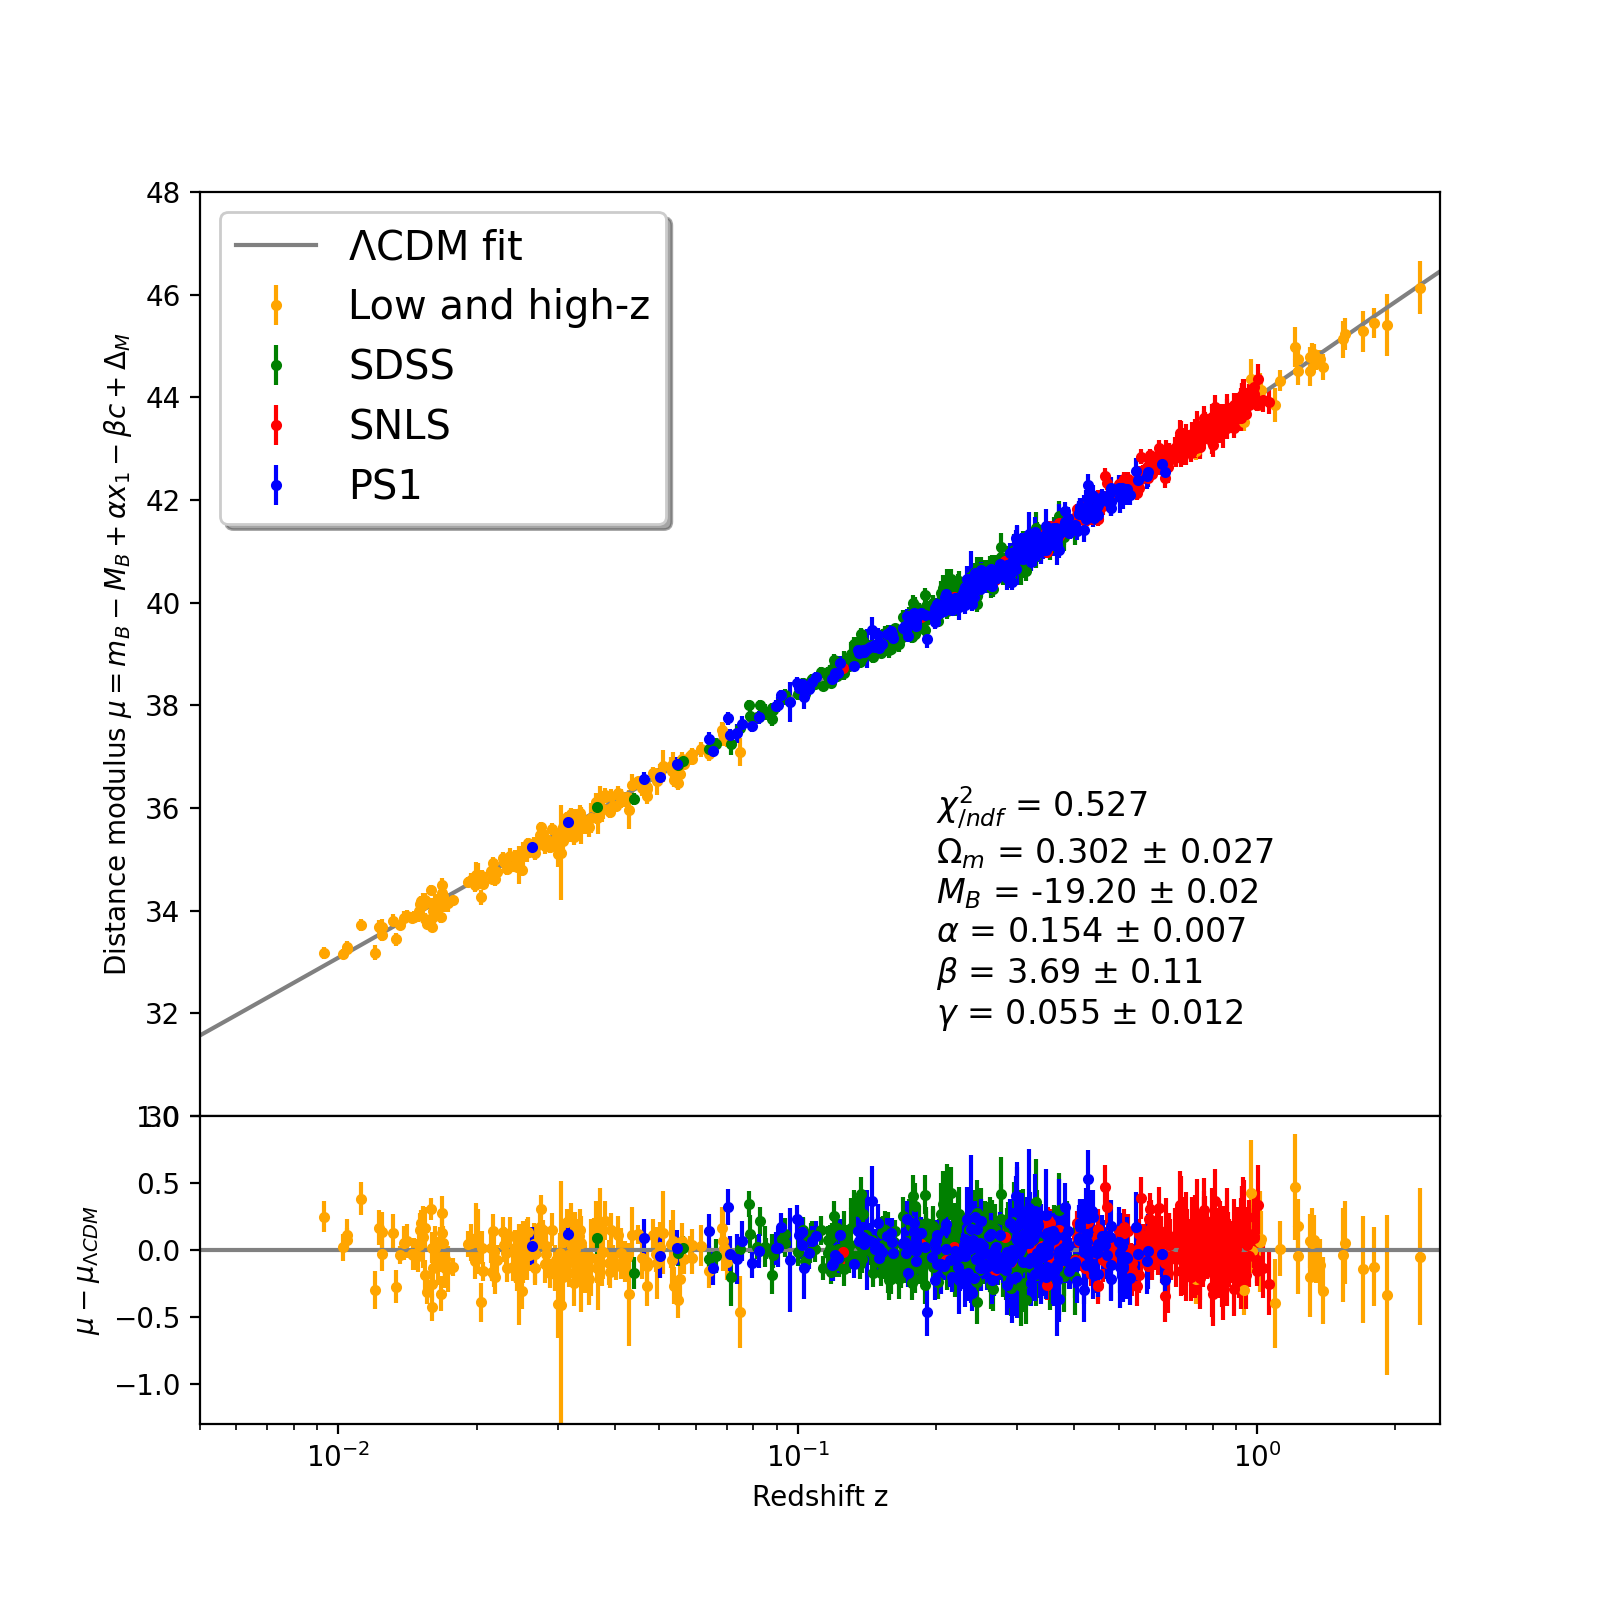

In [14]:
omgM, M_b, alpha, beta, gamma, morph = param_values
domgM, dM_b, dalpha, dbeta, dgamma, dmorph = param_errors


# Experimental and Theoretical (LambdaCDM) distance modulus
SNdata['mu_exp'] = muexp(SNdata, M_b, alpha, beta, gamma, morph)
SNdata['dmu_exp'] = dmuexp(SNdata, alpha, beta)
SNdata['mu_th'] = fitfundL(SNdata['zCMB'], omgM)

# Residual = experimental - theoretical
SNdata['res'] = SNdata['mu_exp'] - SNdata['mu_th']
SNdata['dres'] = SNdata['dmu_exp']
    
# Theoretical curve (LambdaCDM)
xfunc = np.linspace(0.001, 2.5, 1000)
yfunc = fitfundL(xfunc, omgM)

x0 = np.linspace(0.001, 2.5, 1000)
y0 = np.zeros(len(x0))

# Define SN subsamples
setNBandHST = (SNdata['IDSAMPLE'] == 0) | (SNdata['IDSAMPLE'] == 4)
setPS1 = SNdata['IDSAMPLE']==1
setSDSS = SNdata['IDSAMPLE']==2
setSNLS = SNdata['IDSAMPLE']==3

str_fit = f"$\\chi^2_{{/ndf}}$ = {chi2ndf:.3f}\n"
str_fit += f"$\\Omega_m$ = {omgM:.3f} $\pm$ {domgM:.3f}\n"
str_fit += f"$M_B$ = {M_b:.2f} $\pm$ {dM_b:.2f}\n"
str_fit += f"$\\alpha$ = {alpha:.3f} $\pm$ {dalpha:.3f}\n"
str_fit += f"$\\beta$ = {beta:.2f} $\pm$ {dbeta:.2f}\n"
str_fit += f"$\\gamma$ = {gamma:.3f} $\pm$ {dgamma:.3f}\n"


fig, (P1, P2) = plt.subplots(2, 1, figsize=[8, 8], sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))
fig.subplots_adjust(hspace=0)
colors = {'Low and high-z': 'orange', 'PS1': 'blue', 'SDSS': 'green', 'SNLS': 'red'}

for name, set_ in zip(['Low and high-z', 'SDSS', 'SNLS', 'PS1'], [setNBandHST, setSDSS, setSNLS, setPS1]):
    P1.errorbar(SNdata.loc[set_, 'zCMB'], SNdata.loc[set_, 'mu_exp'], yerr=SNdata.loc[set_, 'dmu_exp'],
                marker='.', color=colors[name], linestyle="None", ecolor=colors[name], label=name)
    P2.errorbar(SNdata.loc[set_, 'zCMB'], SNdata.loc[set_, 'res'], yerr=SNdata.loc[set_, 'dres'],
                marker='.', color=colors[name], linestyle="None", ecolor=colors[name])

P1.plot(xfunc, yfunc, c="grey", label="$\Lambda$CDM fit")
P1.set(xlabel='Redshift z', 
       ylabel=r'Distance modulus $\mu = m_B - M_B + \alpha x_1 - \beta c + \Delta_M$',
       xscale='log', 
       xlim=(5e-3, 2.3), ylim=(30, 48))
P1.text(0.2, 31, str_fit, fontsize=12)
P1.legend(loc='best', shadow=True, fontsize='x-large')


P2.plot(x0, y0, c="grey", label="$\Lambda$CDM fit")
P2.set(xlabel='Redshift z',
       ylabel=r'$\mu - \mu_{\Lambda CDM}$',
       xscale='log', 
       xlim=(5e-3, 2.5), ylim=(-1.3, 1))


# P1.plot(SNdata['zCMB'], SNdata['MU'], color="black", marker='+', linestyle="None", label='Pantheon data')
# P2.plot(SNdata['zCMB'], SNdata['MURES'], color="black", marker='+', linestyle="None")

plt.show()

<IPython.core.display.Javascript object>


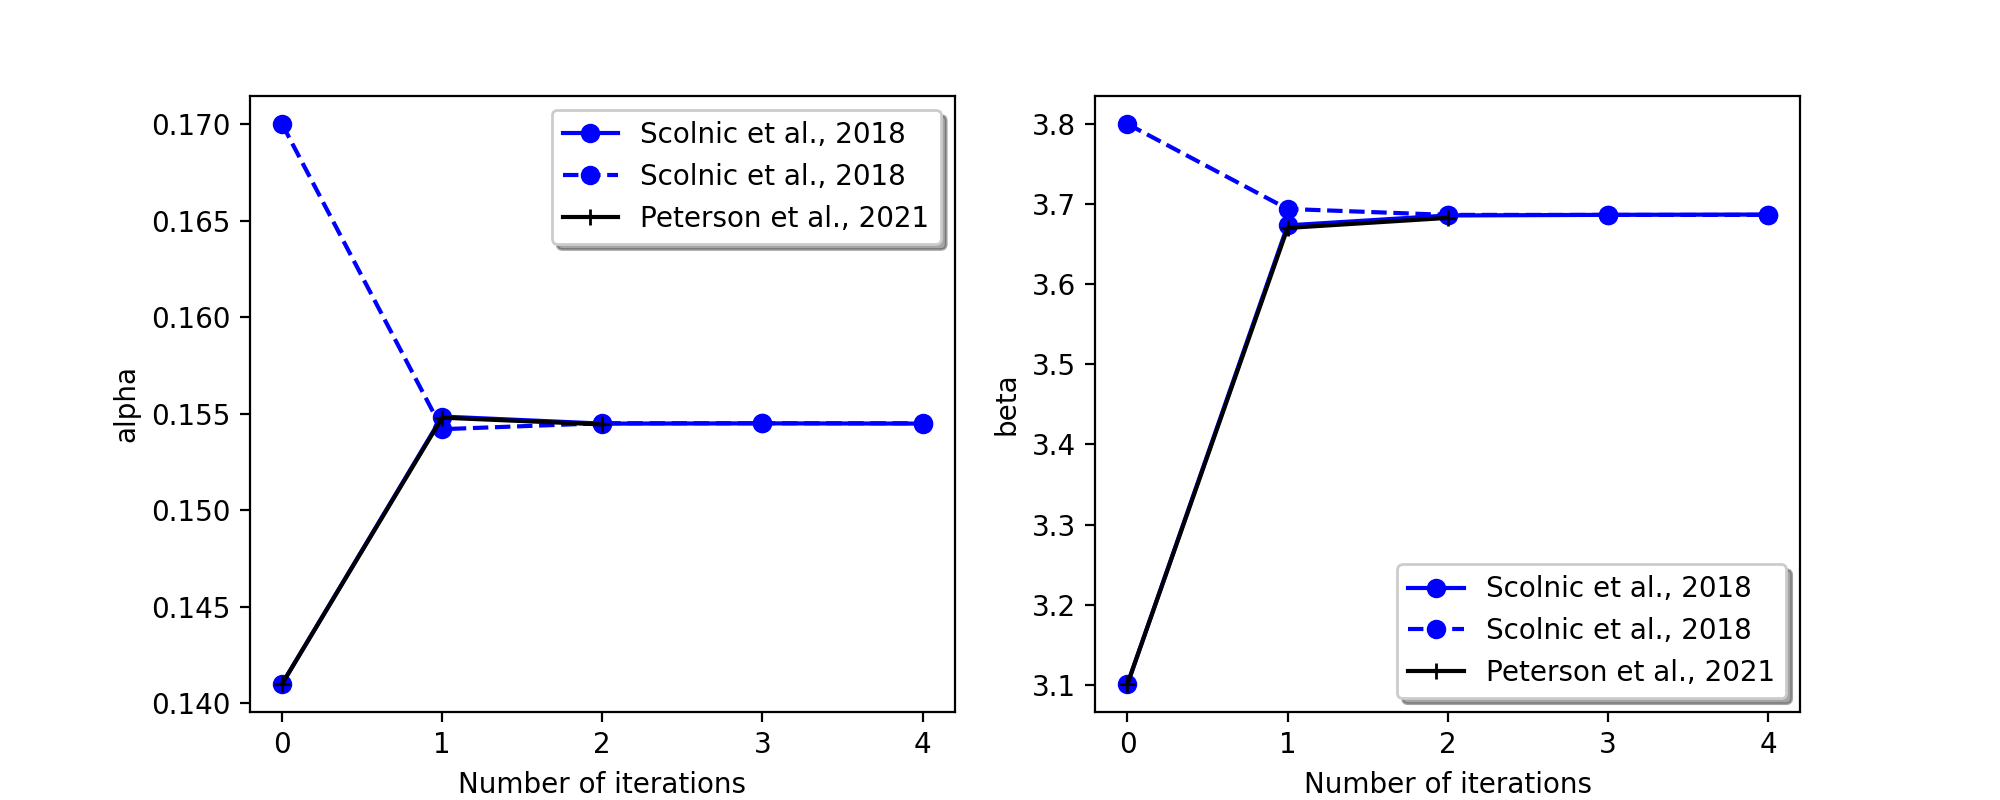

In [15]:
# Convergence of HD fit
it_num = [0, 1, 2, 3, 4]
it_num_new_eq = [0, 1, 2]

alpha_jla = [0.141, 0.1548509682867611, 0.15448439469849296, 0.1544974159619954, 0.15448584736381002]
beta_jla = [3.101, 3.673462780229306, 3.685813625816902, 3.686595019112068, 3.6870023682038306]

alpha_rand = [0.17, 0.15419551429872608, 0.1545046260168899, 0.15450372491968595, 0.15450375183261658]
beta_rand = [3.8, 3.693960806824087, 3.6865451482599223, 3.6865145576022287, 3.686513819776445]

alpha_new_eq = [0.141, 0.15479178271210872, 0.15444209443198997]
beta_new_eq = [3.101, 3.670265615203548, 3.682804903560677]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for ax, ylabel, jla_data, rand_data, new_eq_data in zip([ax1, ax2], 
                                                        ['alpha', 'beta'],
                                                        [alpha_jla, beta_jla],
                                                        [alpha_rand, beta_rand],
                                                        [alpha_new_eq, beta_new_eq]):
    ax.plot(it_num, jla_data, 'b-o', it_num, rand_data, 'b--o', label='Scolnic et al., 2018')
    ax.plot(it_num_new_eq, new_eq_data, 'k-+', label='Peterson et al., 2021')
    ax.set_xlabel("Number of iterations")
    ax.set_ylabel(ylabel)
    ax.legend(loc='best', shadow=True)

plt.show()